In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import random
from collections import Counter
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

<h3> Read file

In [28]:
# Read the TSV file
df = pd.read_csv("a3_train_final.tsv", sep="\t", header=None)

# Add headers "label" and "text"
df.columns = ["label", "text"]

<h3> function to drop -1 and select majority vote.

In [29]:
# Function to process labels
def process_labels(label):
    label_list = label.split("/")
    label_list = [l for l in label_list if l != "-1"]  # Drop -1 labels
    if len(label_list) == 1:
        return label_list[0]  # Return the single label
    else:
        counter = Counter(label_list)
        max_vote = max(counter.values())
        majority_labels = [l for l, count in counter.items() if count == max_vote]
        if len(majority_labels) == 1:
            return random.choice(majority_labels)  # Randomly choose from majority labels
        else:
            return -1

In [30]:
# Apply label processing
df['final_label'] = df['label'].apply(process_labels)

<h3> Drop the indecisive comments

In [31]:
final_df = df[df['final_label'] != -1]
final_df

,label,text,final_label
0,1/1,I'll only consume if I know what's inside it....,1
1,0/-1,It is easier to fool a million people than it...,0
2,0/0,NATURAL IMMUNITY protected us since evolutio...,0
3,0/-1,NATURAL IMMUNITY protected us since evolutio...,0
4,0/0,"Proud to have resisted. Proud of my husband, ...",0
...,...,...,...
50063,0/0,🤣 keep your 💩 I already know 3 people who have...,0
50064,0/0,"🤣🤣🤣 ""JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...",0
50065,0/0,🤣🤣🤣 I took the Vaccine because of work. If I d...,0
50066,0/0,🤨there's people already having severe side eff...,0


<h3> Drop duplicates

In [34]:
# Drop duplicates based on the "text" column in final_df
final_df_tmp = final_df.drop_duplicates(subset=['text'])

# Create a DataFrame containing only the dropped rows in final_df
dropped_rows_df = final_df[~final_df.index.isin(final_df.drop_duplicates(subset=['text']).index)]

# Print the DataFrame with dropped duplicates
print("DataFrame with dropped duplicates:")
print(final_df_temp)

# Print the DataFrame containing dropped rows
print("\nDataFrame containing dropped rows:")
print(dropped_rows_df)

final_df = final_df_tmp

DataFrame with dropped duplicates:
      label                                               text final_label
0       1/1   I'll only consume if I know what's inside it....           1
1      0/-1   It is easier to fool a million people than it...           0
2       0/0   NATURAL IMMUNITY  protected us since evolutio...           0
3      0/-1   NATURAL IMMUNITY  protected us since evolutio...           0
4       0/0   Proud to have resisted. Proud of my husband, ...           0
...     ...                                                ...         ...
50063   0/0  🤣 keep your 💩 I already know 3 people who have...           0
50064   0/0  🤣🤣🤣 "JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...           0
50065   0/0  🤣🤣🤣 I took the Vaccine because of work. If I d...           0
50066   0/0  🤨there's people already having severe side eff...           0
50067   1/1  🥦I ❤my covid vaccines and I'm so excited for m...           1

[47370 rows x 3 columns]

DataFrame containing dropped rows:
   

In [35]:
final_df = final_df.reset_index(drop=True)

In [36]:
final_df

,label,text,final_label
0,1/1,I'll only consume if I know what's inside it....,1
1,0/-1,It is easier to fool a million people than it...,0
2,0/0,NATURAL IMMUNITY protected us since evolutio...,0
3,0/-1,NATURAL IMMUNITY protected us since evolutio...,0
4,0/0,"Proud to have resisted. Proud of my husband, ...",0
...,...,...,...
47365,0/0,🤣 keep your 💩 I already know 3 people who have...,0
47366,0/0,"🤣🤣🤣 ""JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...",0
47367,0/0,🤣🤣🤣 I took the Vaccine because of work. If I d...,0
47368,0/0,🤨there's people already having severe side eff...,0


<h3> Distribution of label 0 and 1

In [37]:
# Count the distribution of 1 and 0 in the final_label column
value_counts = final_df['final_label'].value_counts()
percentage_distribution = final_df['final_label'].value_counts(normalize=True) * 100

# Concatenate count and percentage distribution into a DataFrame
distribution_df = pd.concat([value_counts, percentage_distribution], axis=1)
distribution_df.columns = ['Count', 'Percentage']

# Print the count and percentage distribution
print("Count and Percentage distribution of 1 and 0 in final_label column:")
print(round(distribution_df, 2))

Count and Percentage distribution of 1 and 0 in final_label column:
   Count  Percentage
1  23943       50.54
0  23427       49.46


<H3> Check agreement / disagreement in annotation

In [38]:
# Define function to count disagreements
def count_disagreements(data):
    # Split the labels and remove '-1' for neutrality
    labels = data.str.split("/").apply(lambda x: set(x) - {'-1'})
    
    # Check if both '0' and '1' are present in any label set
    disagreements = sum('0' in label_set and '1' in label_set for label_set in labels)
    
    return disagreements

In [39]:
# Calculate disagreements without dropping rows
disagreements = count_disagreements(df['label'])
print("Number of rows not in agreement:", disagreements)

# Assign agreement status based on the condition
df['agreement'] = df['label'].apply(lambda x: True if len(set(x.split("/")) - {'-1'}) == 1 else False)
df.loc[df['agreement'] == False, 'agreement'] = False

# Print the dataframe
print(df)

# Calculate the proportion of agreement
proportion_agreement = (df['agreement'] == True).sum() / len(df)

print("Proportion of agreement:", round(proportion_agreement, 4))

Number of rows not in agreement: 3001
      label                                               text final_label  \
0       1/1   I'll only consume if I know what's inside it....           1   
1      0/-1   It is easier to fool a million people than it...           0   
2       0/0   NATURAL IMMUNITY  protected us since evolutio...           0   
3      0/-1   NATURAL IMMUNITY  protected us since evolutio...           0   
4       0/0   Proud to have resisted. Proud of my husband, ...           0   
...     ...                                                ...         ...   
50063   0/0  🤣 keep your 💩 I already know 3 people who have...           0   
50064   0/0  🤣🤣🤣 "JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...           0   
50065   0/0  🤣🤣🤣 I took the Vaccine because of work. If I d...           0   
50066   0/0  🤨there's people already having severe side eff...           0   
50067   1/1  🥦I ❤my covid vaccines and I'm so excited for m...           1   

       agreement  
0     

In [10]:
X = df['text']
y = df['final_label']
# Split the data into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into train and validation (60% train, 20% validation of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [11]:
# Pipeline for Logistic Regression with TfidfVectorizer
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

In [12]:
# Define the parameter grid
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2'],  # Regularization penalty
    'clf__solver': ['liblinear', 'saga'],  # Solver algorithm for logistic regression
    'clf__max_iter': [1000],  # Maximum number of iterations
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__C': 1.0, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}


In [26]:
# Use the best estimator from grid search to predict labels on the validation set
y_train_pred = grid_search.best_estimator_.predict(X_train)

# Print the classification report
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     14057
           1       0.85      0.84      0.84     14368

    accuracy                           0.84     28425
   macro avg       0.84      0.84      0.84     28425
weighted avg       0.84      0.84      0.84     28425



In [14]:
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      4640
           1       0.82      0.80      0.81      4835

    accuracy                           0.81      9475
   macro avg       0.81      0.81      0.81      9475
weighted avg       0.81      0.81      0.81      9475



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      4640
           1       0.82      0.80      0.81      4835

    accuracy                           0.81      9475
   macro avg       0.81      0.81      0.81      9475
weighted avg       0.81      0.81      0.81      9475



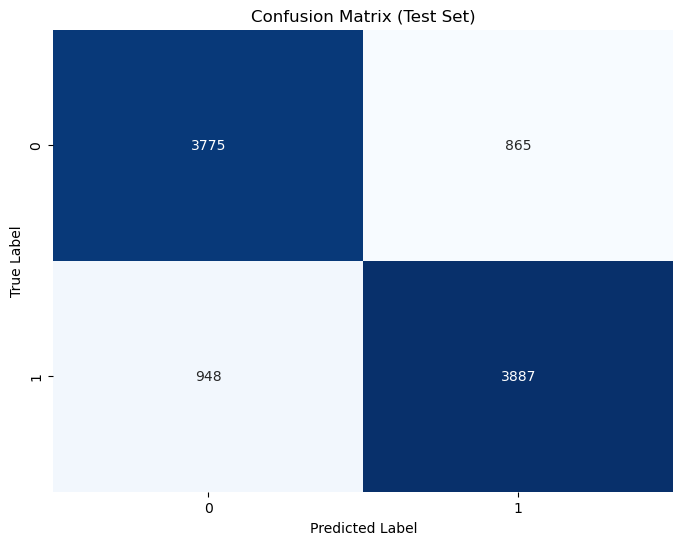

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict labels on the test set using the best estimator from grid search
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Compute confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [23]:
# Predict labels and probabilities on the test set using the best estimator from grid search
y_test_pred = grid_search.best_estimator_.predict(X_test)
y_test_prob = grid_search.best_estimator_.predict_proba(X_test)

# Initialize lists to store misclassified comments and their probabilities
misclassified_comments = []
misclassified_true_labels = []
misclassified_predicted_labels = []
misclassified_probabilities = []

# Iterate through each comment, true label, predicted label, and probability
for comment, true_label, pred_label, probs in zip(X_test, y_test, y_test_pred, y_test_prob):
    if true_label != pred_label:
        misclassified_comments.append(comment)
        misclassified_true_labels.append(true_label)
        misclassified_predicted_labels.append(pred_label)
        misclassified_probabilities.append(probs)

# Iterate through the first 10 misclassified comments
for i in range(min(10, len(misclassified_comments))):
    comment = misclassified_comments[i]
    true_label = misclassified_true_labels[i]
    pred_label = misclassified_predicted_labels[i]
    probs = misclassified_probabilities[i]

    print("Misclassified Comment:", comment)
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Probabilities:", probs)
    print()

Misclassified Comment: I have never made a better decision in my life protecting the majority of my family by getting the vaccine.
True Label: 1
Predicted Label: 0
Probabilities: [0.65656858 0.34343142]

Misclassified Comment: It really is, but I think plenty of people have been lead/tricked/manipulated into it, through good intentions. I’ve listened to many people on podcasts, and just out in the world repeat this line of thinking (“thank god I was vaccinated, or it would be worse”, and “DUH! You obviously can still get it after being vaccinated”), and I don’t think there’s any getting through to these people. Their common sense is suspended at the moment, at the very least.
True Label: 0
Predicted Label: 1
Probabilities: [0.31735608 0.68264392]

Misclassified Comment: USA citizens need to step up like the Canadians did to end the no vaxx no entry border mandates. This hurts tourism, is keeping families apart. It's time to end!!!
True Label: 0
Predicted Label: 1
Probabilities: [0.4074

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get the TF-IDF vectorizer from the best estimator
tfidf_vectorizer = best_classifier.named_steps['tfidf']

# Transform the misclassified comments to TF-IDF matrix
X_test_tfidf = tfidf_vectorizer.transform(misclassified_comments)

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Iterate through the first 10 misclassified comments
for i in range(min(10, len(misclassified_comments))):
    comment = misclassified_comments[i]
    print("Misclassified Comment:", comment)
    print("True Label:", misclassified_true_labels[i])
    print("Predicted Label:", misclassified_predicted_labels[i])
    print("Probabilities:", misclassified_probabilities[i])
    print("Top 10 words and their TF-IDF values:")

    # Sort TF-IDF values and get indices of top 10
    top_indices = X_test_tfidf[i].toarray()[0].argsort()[-10:][::-1]

    # Print top 10 words and their TF-IDF values
    for index in top_indices:
        word = feature_names[index]
        tfidf_value = X_test_tfidf[i].toarray()[0][index]
        print(f"Word: {word}, TF-IDF: {tfidf_value}")

    print()


Misclassified Comment: I have never made a better decision in my life protecting the majority of my family by getting the vaccine.
True Label: 1
Predicted Label: 0
Probabilities: [0.65656858 0.34343142]
Top 10 words and their TF-IDF values:
Word: the majority, TF-IDF: 0.2831883883066711
Word: by getting, TF-IDF: 0.2751459944567058
Word: majority of, TF-IDF: 0.26284757018180993
Word: have never, TF-IDF: 0.2575026100039497
Word: majority, TF-IDF: 0.2535565026138577
Word: protecting, TF-IDF: 0.2524479230706091
Word: decision, TF-IDF: 0.2351625129916114
Word: my life, TF-IDF: 0.23402083667748388
Word: my family, TF-IDF: 0.2156268470552376
Word: of my, TF-IDF: 0.21242693409518518

Misclassified Comment: It really is, but I think plenty of people have been lead/tricked/manipulated into it, through good intentions. I’ve listened to many people on podcasts, and just out in the world repeat this line of thinking (“thank god I was vaccinated, or it would be worse”, and “DUH! You obviously can st